In [8]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


In [9]:
import torch
torch.cuda.is_available()

True

In [3]:
data_dirs = {
    "train": "./rgb_dataset/train",
    "test": "./rgb_dataset/test",
    "val": "./rgb_dataset/val"
}

keypoints_dir = "keypoints_dataset"

os.makedirs(keypoints_dir, exist_ok=True)

In [10]:
EPOCHS = 100
RANDOM_SEED = 40
BATCH_SIZE = 32
EMOTIONS = ['angry', 'confused', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'shy', 'surprise']

In [33]:
mp_holistic = mp.solutions.holistic # Holistic model 
mp_drawing = mp.solutions.drawing_utils # Drawing utilities 
mp_face_mesh = mp.solutions.face_mesh

In [11]:
def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.setflags(write=False)         # Image is no longer writable
    results = model.process(image)      # Make prediction
    image.setflags(write=True)          # Image is now writable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


In [30]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
def extract_keypoints(results):
    face = np.array([[lm.x, lm.y, lm.z] for lm in results.face_landmarks.landmark]).flatten() \
           if results.face_landmarks else np.zeros(468*3)
    pose = np.zeros(33*3)
    lh = np.zeros(21*3)
    rh = np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [ ]:
# #same logic as above but in function, so can be used
# def extract_keypoints(results):
#     pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
#     return np.concatenate([pose, face, lh, rh]) # flatten arr of points x,y,z visibility values - single vector

In [6]:
with mp_holistic.Holistic(static_image_mode=True) as holistic:
    for split, split_dir in data_dirs.items():
        for class_name in sorted(os.listdir(split_dir)):
            class_path = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            
            # Make parallel folder in keypoints_dir
            save_class_path = os.path.join(keypoints_dir, split, class_name)
            os.makedirs(save_class_path, exist_ok=True)
            
            for img_name in os.listdir(class_path):
                if img_name.startswith("."):  # skip hidden files
                    continue
                img_path = os.path.join(class_path, img_name)
                
                # Read, convert, resize
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))
                
                # Extract keypoints
                results = holistic.process(img)
                keypoints = extract_keypoints(results)
                
                # Save keypoints as .npy
                save_path = os.path.join(save_class_path, img_name.split('.')[0] + ".npy")
                np.save(save_path, keypoints)

print("Keypoints saved in folder:", keypoints_dir)

Keypoints saved in folder: keypoints_dataset


In [17]:
folder = "keypoints_dataset/train/happy"

# List all .npy files
files = [f for f in os.listdir(folder) if f.endswith(".npy")]

first_img = os.path.join(folder, files[0])
keypoints = np.load(first_img)
print(keypoints.shape)

(1629,)


In [18]:
# Load keypoints arrays
def load_keypoints_dataset(base_dir):
    X, y = [], []
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            if not file.endswith(".npy"):
                continue
            keypoints = np.load(os.path.join(class_path, file))
            X.append(keypoints)
            y.append(class_name)
    return np.array(X), np.array(y)

# Example: train dataset
X, y = load_keypoints_dataset("keypoints_dataset/train")

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)  # one-hot encoding for MLP

# Split further into train/val if needed
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

(15033, 1629) (15033, 9)


In [19]:
num_classes = y_train.shape[1]

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       834,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,945 (3.81 MB)

 Trainable params: 999,945 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
csv_logger = CSVLogger('training_log.csv')

In [21]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[es, mc, csv_logger]
)

Epoch 1/50
456/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1150 - loss: 2.2442

470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1181 - loss: 2.2112 - val_accuracy: 0.1341 - val_loss: 2.1886
Epoch 2/50
461/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1260 - loss: 2.1876

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1310 - loss: 2.1840 - val_accuracy: 0.1378 - val_loss: 2.1761
Epoch 3/50
464/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1337 - loss: 2.1805

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1356 - loss: 2.1776 - val_accuracy: 0.1498 - val_loss: 2.1686
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1354 - loss: 2.1783 - val_accuracy: 0.1391 - val_loss: 2.1776
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1403 - loss: 2.1754 - val_accuracy: 0.1492 - val_loss: 2.1695
Epoch 6/50
469/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1410 - loss: 2.1747

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1399 - loss: 2.1764 - val_accuracy: 0.1554 - val_loss: 2.1686
Epoch 7/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1414 - loss: 2.1732 - val_accuracy: 0.1503 - val_loss: 2.1662
Epoch 8/50
464/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1426 - loss: 2.1744

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1412 - loss: 2.1731 - val_accuracy: 0.1604 - val_loss: 2.1695
Epoch 9/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1404 - loss: 2.1717 - val_accuracy: 0.1484 - val_loss: 2.1679
Epoch 10/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1439 - loss: 2.1730 - val_accuracy: 0.1564 - val_loss: 2.1652
Epoch 11/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1407 - loss: 2.1722 - val_accuracy: 0.1599 - val_loss: 2.1651
Epoch 12/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1453 - loss: 2.1701 - val_accuracy: 0.1564 - val_loss: 2.1648
Epoch 13/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1444 - loss: 2.1716 - val_accuracy: 0.1508 - val_loss: 2.1691
Epoch 14/50
464/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1474 - loss: 2.1700

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1473 - loss: 2.1704 - val_accuracy: 0.1633 - val_loss: 2.1565
Epoch 15/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1469 - loss: 2.1712 - val_accuracy: 0.1532 - val_loss: 2.1683
Epoch 16/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1481 - loss: 2.1690

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1504 - loss: 2.1685 - val_accuracy: 0.1671 - val_loss: 2.1534
Epoch 17/50
467/470 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1448 - loss: 2.1696

470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1455 - loss: 2.1682 - val_accuracy: 0.1719 - val_loss: 2.1513
Epoch 18/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1521 - loss: 2.1650 - val_accuracy: 0.1649 - val_loss: 2.1558
Epoch 19/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1587 - loss: 2.1534 - val_accuracy: 0.1615 - val_loss: 2.1519
Epoch 20/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1624 - loss: 2.1488 - val_accuracy: 0.1676 - val_loss: 2.1424
Epoch 21/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1605 - loss: 2.1540 - val_accuracy: 0.1205 - val_loss: 2.1887
Epoch 22/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1250 - loss: 2.1862 - val_accuracy: 0.1202 - val_loss: 2.1883
Epoch 23/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1261 - loss: 2.1855 - val_accuracy: 0.1617 - val_loss: 2.1743
Epoch 24/50
466/470 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1598 - loss: 2.1601

470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1575 - loss: 2.1562 - val_accuracy: 0.1788 - val_loss: 2.1363
Epoch 25/50
466/470 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1668 - loss: 2.1438

470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1600 - loss: 2.1459 - val_accuracy: 0.1913 - val_loss: 2.1091
Epoch 26/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1652 - loss: 2.1396 - val_accuracy: 0.1838 - val_loss: 2.1230
Epoch 27/50
464/470 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1692 - loss: 2.1405

470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1706 - loss: 2.1393 - val_accuracy: 0.1929 - val_loss: 2.1256
Epoch 28/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1751 - loss: 2.1346 - val_accuracy: 0.1910 - val_loss: 2.1230
Epoch 29/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1743 - loss: 2.1293 - val_accuracy: 0.1862 - val_loss: 2.1272
Epoch 30/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1782 - loss: 2.1271 - val_accuracy: 0.1586 - val_loss: 2.1685
Epoch 31/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1714 - loss: 2.1249 - val_accuracy: 0.1367 - val_loss: 2.2388
Epoch 32/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1731 - loss: 2.1200 - val_accuracy: 0.1250 - val_loss: 2.2169
Epoch 33/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1743 - loss: 2.1186 - val_accuracy: 0.1266 - val_loss: 2.2236
Epoch 34/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1779 - loss: 2.1133 - val_accuracy: 0.1617

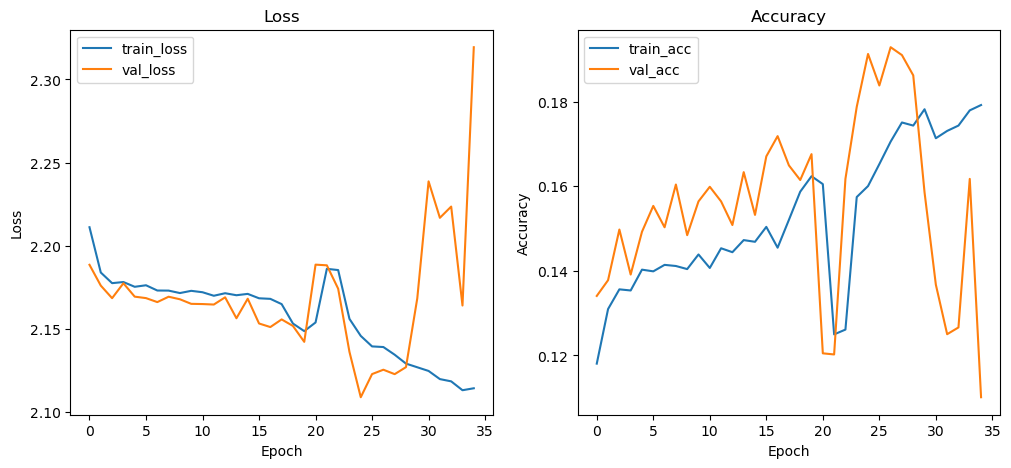

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")

In [24]:
# import os
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# Load keypoints arrays and labels
def load_keypoints_dataset(base_dir):
    X, y = [], []
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            if not file.endswith(".npy"):
                continue
            keypoints = np.load(os.path.join(class_path, file))
            X.append(keypoints)
            y.append(class_name)
    return np.array(X), np.array(y)

# Example: test dataset
X_test, y_test = load_keypoints_dataset("keypoints_dataset/test")

# Encode labels to integers
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test_enc)  # one-hot for Keras

In [25]:
# from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("best_model.h5")

# Predict probabilities
yhat_probs = model.predict(X_test)  # shape (num_samples, 9)

# Convert probabilities to predicted class indices
yhat = np.argmax(yhat_probs, axis=1)

# True class indices
ytrue = np.argmax(y_test_cat, axis=1)  # if using one-hot
# OR if using encoded labels directly:
# ytrue = y_test_enc

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(ytrue, yhat)
print(f"Test Accuracy: {acc*100:.2f}%")